In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data sets

In [111]:
df_energy = pd.read_csv("./data/energy_dataset.csv", parse_dates = ["time"])
df_weather = pd.read_csv("./data/weather_features.csv", parse_dates = ["dt_iso"])

## Energy Data Cleaning

In [112]:
df_energy.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.0,35046.00,35046.00,35045.00,35046.0,35046.0,35046.0,0.0,...,35045.00,35046.0,35046.00,35064.00,0.0,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,0.0,5622.74,4256.07,298.32,0.0,0.0,0.0,NaN,...,269.45,0.0,5464.48,1439.07,NaN,5471.22,28712.13,28696.94,49.87,57.88
std,85.35,354.57,0.0,2201.83,1961.60,52.52,0.0,0.0,0.0,NaN,...,50.20,0.0,3213.69,1677.70,NaN,3176.31,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,NaN,...,0.00,0.0,0.00,0.00,NaN,237.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,0.0,4126.00,2527.00,263.00,0.0,0.0,0.0,NaN,...,240.00,0.0,2933.00,69.00,NaN,2979.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,0.0,4969.00,4474.00,300.00,0.0,0.0,0.0,NaN,...,279.00,0.0,4849.00,576.00,NaN,4855.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,0.0,6429.00,5838.75,330.00,0.0,0.0,0.0,NaN,...,310.00,0.0,7398.00,2636.00,NaN,7353.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,0.0,20034.00,8359.00,449.00,0.0,0.0,0.0,NaN,...,357.00,0.0,17436.00,5836.00,NaN,17430.00,41390.00,41015.00,101.99,116.80


Some columns are full of zeros and others are full af NaNs. We have to drop these attributes as they are useless

In [113]:
print(f"Energy dataset shape: {df_energy.shape} \nEnergy dataset attributes and their types: ")
df_energy.dtypes

Energy dataset shape: (35064, 29) 
Energy dataset attributes and their types: 


time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

In [114]:
# time attribute wasn't parsed correctly, thus we will update its format and set it as the index of the energy data set

df_energy['time'] = pd.to_datetime(df_energy['time'], utc = True)
df_energy = df_energy.set_index('time')

In [115]:
# Drop columns with a number of missing values or zeros above the treshold

threshold = 0.3  # 30% missing data or zeros allowed

# Fraction of missing values per column
missing_fraction = df_energy.isna().mean()

# Fraction of zero values per column
zero_fraction = (df_energy == 0).mean()

# Combined fraction: missing OR zero
combined_fraction = missing_fraction + zero_fraction

# Identify columns to drop
cols_to_drop = combined_fraction[combined_fraction > threshold].index

print(f"Dropping the following columns due to > {threshold*100:.0f}% missing or zero values:")
print(list(cols_to_drop))

# Drop the columns
df_energy = df_energy.drop(columns=cols_to_drop)

Dropping the following columns due to > 30% missing or zero values:
['generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead']


In [116]:
# Find NaNs and duplicates in df_energy

print(f"There are {df_energy.isnull().values.sum()} missing values in df_energy")

temp_energy = df_energy.duplicated(keep = 'first').sum()
print(f"There are {temp_energy} duplicate rows in df_energy based on all columns")

There are 255 missing values in df_energy
There are 0 duplicate rows in df_energy based on all columns


We can't drop rows with Nan values since we are using time series data, thus we will have to fill them using interpolation

In [117]:
# Find the number of NaNs in each column
df_energy.isnull().sum(axis = 0)

generation biomass                            19
generation fossil gas                         18
generation fossil hard coal                   18
generation fossil oil                         19
generation hydro run-of-river and poundage    19
generation hydro water reservoir              18
generation nuclear                            17
generation other                              18
generation other renewable                    18
generation solar                              18
generation waste                              19
generation wind onshore                       18
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                             36
price day ahead                                0
price actual                                   0
dtype: int64

In [118]:
# Fill null values using interpolation
df_energy.interpolate(method = 'linear', limit_direction = 'forward', axis = 0, inplace = True)

Now that we have cleaned the energy dataset we can move analyze the correlation between the attributes

In [119]:
# Compute absolute correlation matrix
corr_matrix = df_energy.corr(numeric_only = True).abs()

plot_corr_matrix = False
if plot_corr_matrix:
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=18)
    plt.show()

In [120]:
# Set correlation threshold
threshold = 0.85

# Store correlated pairs
correlated_pairs = []

# Loop through upper triangle of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            correlated_pairs.append((col1, col2, corr_value))

# Show results
for col1, col2, corr_value in correlated_pairs:
    print(f"{col1} ↔ {col2} : correlation = {corr_value:.2f}")

generation solar ↔ forecast solar day ahead : correlation = 0.99
generation wind onshore ↔ forecast wind onshore day ahead : correlation = 0.99
total load forecast ↔ total load actual : correlation = 1.00


In [121]:
# Drop the forecast attributes
df_energy.drop(columns = ["forecast solar day ahead", "forecast wind onshore day ahead", "total load forecast"], inplace = True)

## Weather Data Cleaning

In [122]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


We can identify the presence of outliers in pressure column since the max value is vary high and the min value is very low, and possibly there are outliers in wind_speed too since the max value is way higher than the 75th percentile. We will analyze these two attributes later to find out if these values are outliers or not

In [123]:
print(f"Weather dataset shape: {df_weather.shape} \nWeather dataset attributes and their types: ")
df_weather.dtypes

Weather dataset shape: (178396, 17) 
Weather dataset attributes and their types: 


dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

We notice the following:
1. time (dt_iso) attribute wasn't properly parsed
2. We have to turn int64 data into float64, this is required to find NaN values as they are specific to float, and to do interpolation if needed
3. Some object type data attributes should be turned into numeric data

In [124]:
# Rename dt_iso by time
df_weather.rename(columns = {'dt_iso': 'time'}, inplace = True)

In [125]:
# Turn all attributes of type int64 into float64
df_weather = df_weather.astype({col: 'float64' for col in df_weather.select_dtypes(include=['int64']).columns})

In [126]:
# Drop weather_icon column since it is irrelevant for our work
df_weather.drop(columns = ["weather_icon"], inplace = True)

In [127]:
# Find the number of NaNs in each column
print(f"There are {sum(df_weather.isnull().sum(axis = 0))} missing values in the weather dataset")

There are 0 missing values in the weather dataset


Remove outliers, and recompute their values using interpolation

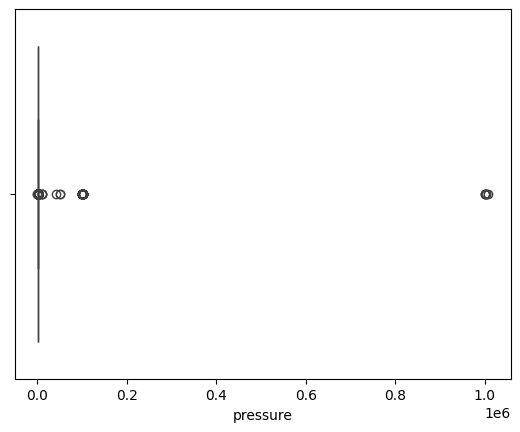

In [128]:
# Check for outliers in pressure column
sns.boxplot(x = df_weather["pressure"])
plt.show()

In [129]:
# Replace outliers in pressure with NaNs
df_weather.loc[df_weather.pressure > 1051, "pressure"] = np.nan
df_weather.loc[df_weather.pressure < 931, "pressure"] = np.nan

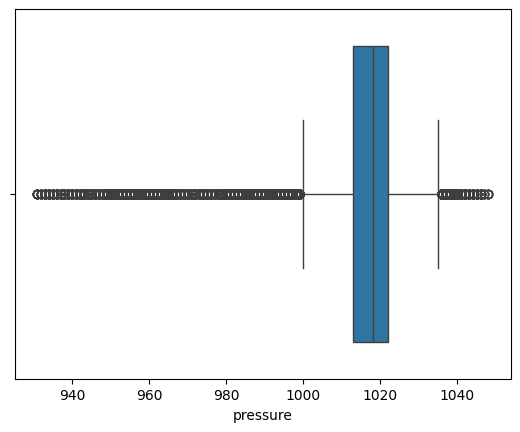

In [130]:
# Check for outliers in pressure column after the update 
sns.boxplot(x = df_weather["pressure"])
plt.show()

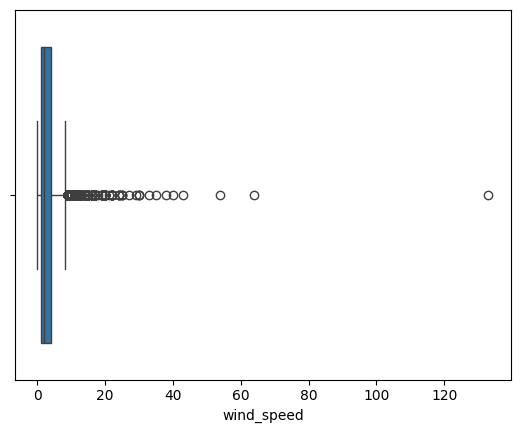

In [131]:
# Check for outliers in wind_speed column
sns.boxplot(x = df_weather["wind_speed"])
plt.show()

In [132]:
# Replace outliers in wind_speed with NaNs
df_weather.loc[df_weather.wind_speed > 50, "wind_speed"] = np.nan

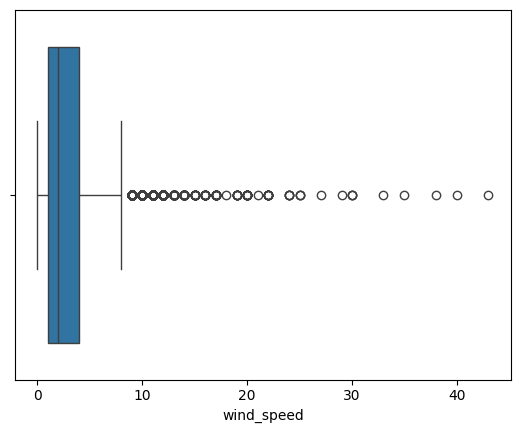

In [133]:
# Check for outliers in wind_speed column after the update
sns.boxplot(x = df_weather["wind_speed"])
plt.show()

Now that we removed the outliers, we can replace their previous values with interpolations

In [134]:
# Fill null values using interpolation
df_weather.interpolate(method = 'linear', limit_direction = 'forward', axis = 0, inplace = True)

C:\Users\oussa\AppData\Local\Temp\ipykernel_26000\1724543761.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method = 'linear', limit_direction = 'forward', axis = 0, inplace = True)


All outliers cleared. Next we can look for duplicates and remove them if there are any. \
A duplicate is a row with the same (time, city_name) attributes as another row even if they have different values on the other attributes.

In [135]:
# Check for NaNs
print(f"There are {df_weather.isnull().values.sum()} missing values in df_weather")

# Count duplicates
temp_energy = df_weather.duplicated(keep = 'first').sum()
print(f"There are {temp_energy} duplicate rows in df_weather based on all columns")

temp_energy = df_weather.duplicated(subset = ['time', 'city_name'], keep = 'first').sum()
print(f"There are {temp_energy} duplicate rows in df_weather based on ('time', 'city_name') columns")

# Drop duplicates (keep first occurrence)
df_weather.drop_duplicates(subset = ['time', 'city_name'], keep = 'first', inplace = True)

There are 0 missing values in df_weather
There are 21 duplicate rows in df_weather based on all columns
There are 3076 duplicate rows in df_weather based on ('time', 'city_name') columns


Now that we cleared duplicates we can set time as a dataset index

In [136]:
# Turn time attribute into a dataset index
df_weather['time'] = pd.to_datetime(df_weather['time'], utc = True)
df_weather = df_weather.set_index('time')

In [137]:
# Display the number of rows in each dataframe
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


Now we are ready to merge energy and weather datasets, but before that we should turn all object attributes of the weather dataset into numric attributes

weather_main, weather_description and weather_icon attributes communicate the same information, we should determine which one of these columns to preserve and drop the other two.

In [138]:
from sklearn.preprocessing import LabelEncoder

In [139]:
le = LabelEncoder()
corr_matrix = pd.DataFrame({
    'weather_id': le.fit_transform(df_weather['weather_id']),
    'weather_main': le.fit_transform(df_weather['weather_main']),
    'weather_description': le.fit_transform(df_weather['weather_description'])
}).corr()

print(corr_matrix)

                     weather_id  weather_main  weather_description
weather_id             1.000000     -0.878804             0.060279
weather_main          -0.878804      1.000000            -0.306276
weather_description    0.060279     -0.306276             1.000000


weather_id and weather_main are highly correlated, we will drop weather_id and keep weather_main

In [140]:
df_weather.drop(columns = ["weather_id"], inplace = True)

We will use Label Encoding to turn weather_main and weather_description into numeric data

In [141]:
le_main = LabelEncoder()
df_weather['weather_main'] = le_main.fit_transform(df_weather['weather_main'])

le_desc = LabelEncoder()
df_weather['weather_description'] = le_desc.fit_transform(df_weather['weather_description'])

Let's see the correlation between the attributes of the weather dataset 

In [142]:
# Compute absolute correlation matrix
corr_matrix = df_weather.corr(numeric_only=True).abs()

plot_corr_matrix = False
if plot_corr_matrix:
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=18)
    plt.show()

In [143]:
# Set correlation threshold
threshold = 0.85

# Store correlated pairs
correlated_pairs = []

# Loop through upper triangle of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            correlated_pairs.append((col1, col2, corr_value))

# Show results
for col1, col2, corr_value in correlated_pairs:
    print(f"{col1} ↔ {col2} : correlation = {corr_value:.2f}")

temp ↔ temp_min : correlation = 0.97
temp ↔ temp_max : correlation = 0.97
temp_min ↔ temp_max : correlation = 0.89


In [144]:
# Drop temp_min and temp_max attributes
df_weather.drop(columns = ["temp_min", "temp_max"], inplace = True)

## Merge energy and weather datasets

First of all we split the weather dataset into five separate datasets each for one of the five cities we have

In [145]:
df_w_1, df_w_2, df_w_3, df_w_4, df_w_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_w_1, df_w_2, df_w_3, df_w_4, df_w_5]

In [146]:
# Merge all dataframes into the final dataframe (df_final)
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on = ['time'], how = 'outer')
    df_final = df_final.drop(f"city_name_{city_str}", axis=1)

In [147]:
# Display the number of NaNs and duplicates in the final dataframe

print(f"There are {df_final.isnull().values.sum()} missing values or NaNs in df_final.")

temp_final = df_final.duplicated(keep = 'first').sum()
print(f"There are {temp_final} duplicate rows in df_energy based on all columns.")

There are 0 missing values or NaNs in df_final.
There are 0 duplicate rows in df_energy based on all columns.


In [1]:
# Save the final dataframe
if False:
    df_final.to_csv('./data/final_dataset.csv', index = True) # (index = True) is used to conserve time attribute although it is considered as an index 